In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.formula.api as sm
from tqdm import tqdm; tqdm.pandas();
from src.dag import grn
import pickle
import os
import scipy
import itertools

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors)

%matplotlib inline

# Simulations

In [2]:
n_sims = 2000
n_genes = 1000

table_file = 'figdata/fig5_grns.parquet'
graph_file = 'figdata/fig5_grns.list.pkl'

if False and os.path.exists(table_file) and os.path.exists(graph_file):
    grns = pd.read_parquet(table_file)
    G_s = pickle.load(open(graph_file, 'rb'))
else:
    grns = pd.DataFrame({
        'n': n_genes,
        'r': np.random.uniform(3, 12, size=n_sims),
        'k': np.random.randint(1, 50, size=n_sims),
        'w': 2**np.random.uniform(0, np.log2(100), size=n_sims),
        'd': 2**np.random.uniform(0, np.log2(30), size=n_sims),
        'gamma': np.random.uniform(0.1, 0.5, size=n_sims),
        'p_up': np.random.uniform(0, 1, size=n_sims),
        'hier': np.random.choice([False, True], size=n_sims)
    })
    grns['m'] = grns['w'] / (grns['w'] + grns['k'] - 1)

    G_s = [grn().add_structure(method='dsfg',
                              n_genes = row.n, 
                              n_groups = row.k,
                              r = row.r,
                              w = row.w,
                              d = row.d,
                              hierarchy = row.hier
               ).add_expression_parameters(
                              sign = np.random.choice([-1, 1], p=[1 - row.p_up, row.p_up], size=(row.n, 1)),
                              weight = row.gamma
               ).compute_h2() 
           for _,row in tqdm(grns.iterrows())
    ]

    grns[r'$V_{cis}/V_{tot}$'] = [G.cish2 for G in G_s]
    grns['Median '+r'$V_{cis}/V_{tot}$'] = grns[r'$V_{cis}/V_{tot}$'].apply(np.median)
    
    # save
    grns.to_parquet(table_file)
    pickle.dump(G_s, open(graph_file, 'wb'))
    
display(grns.head(), len(G_s))

2000it [31:25,  1.06it/s]


,n,r,k,w,d,gamma,p_up,hier,m,$V_{cis}/V_{tot}$,Median $V_{cis}/V_{tot}$
0,1000,8.424522,28,7.543687,2.103666,0.232227,0.855770,False,0.218381,"[1.0, 1.0, 1.0, 1.0, 0.9488301550415839, 1.0, ...",0.558633
1,1000,8.699302,5,1.557407,5.197157,0.240450,0.404084,False,0.280240,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.602907
2,1000,6.479820,31,2.495621,4.454686,0.108149,0.206114,False,0.076799,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.931546
3,1000,4.582399,24,42.057254,9.845337,0.285120,0.238473,False,0.646465,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.715736
4,1000,7.647557,32,12.522398,14.187627,0.271040,0.372002,False,0.287723,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.541418


2000

# Figure 4

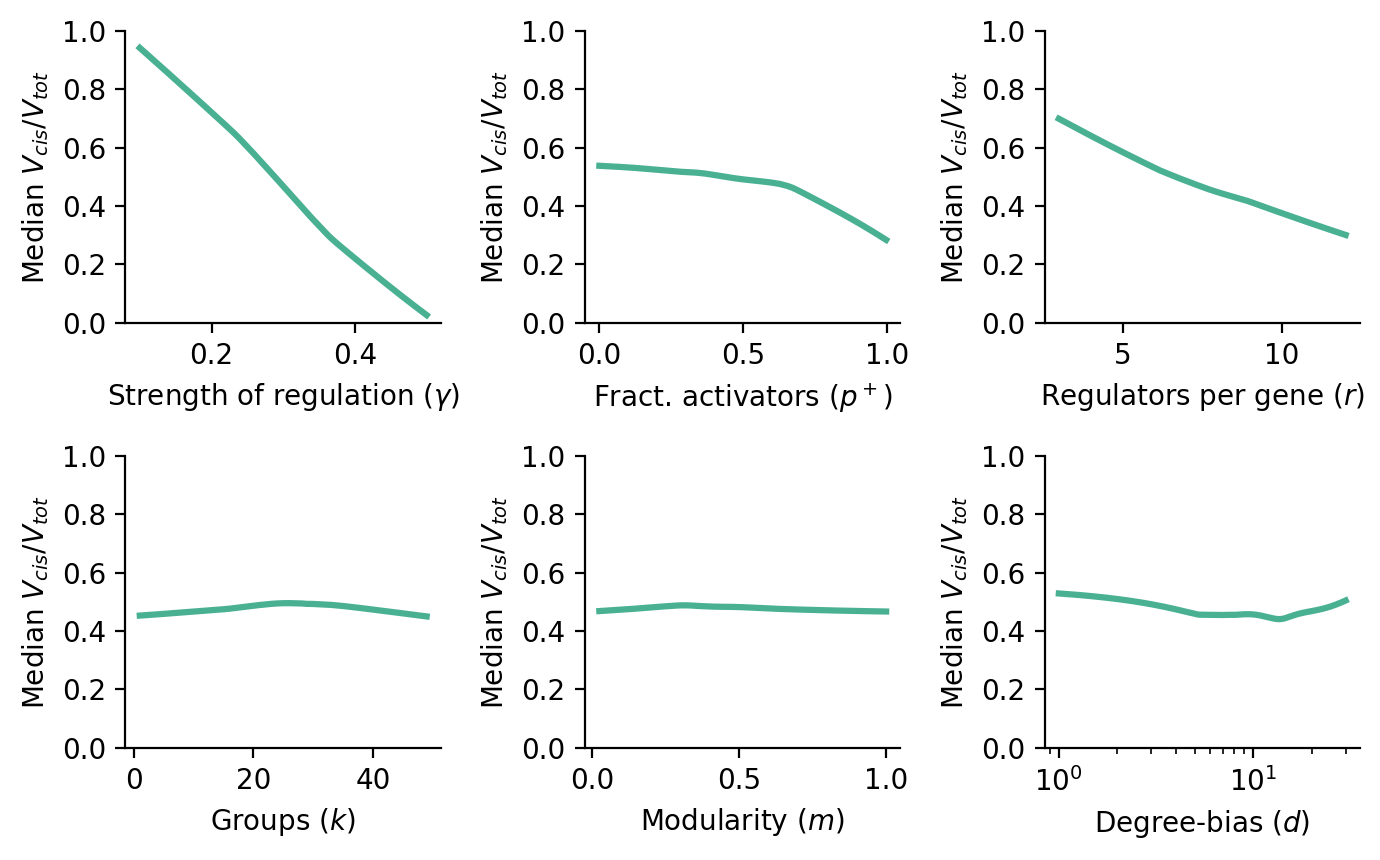

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                ['gamma','p_up','r','k','m','d'],
                                ['Strength of regulation ({})'.format(r'$\gamma$'), 
                                 'Fract. activators ({})'.format(r'$p^+$'),
                                 'Regulators per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$m$'), 
                                 'Degree-bias ({})'.format(r'$d$')
                                 ]):
    ax = axs[ix, iy]
    for i, b in enumerate([1]):
        sns.regplot(data = grns.loc[grns['hier']==b], 
                    x = par, 
                    y = 'Median '+r'$V_{cis}/V_{tot}$', 
                    color = plt.get_cmap('Dark2')(i),
                    lowess = True,
                    scatter = True,
                    line_kws = dict(alpha=0.8, label=('No ' if not b else '')+'Hierarchy'),
                    scatter_kws = dict(s=0.0, alpha=0.3, label=None),
                    ax = ax
                   )
    ax.set_ylim(0, 1);
    ax.set_xlabel(label);
    if par == 'd':
        ax.set_xscale('log');
    #if ix == 0 and iy == 0:
    #    ax.legend(fontsize=7.5, frameon=False, loc='upper right');

# overall figure stuff
sns.despine();
fig.tight_layout();

# Supplement

## Figure version with all the points

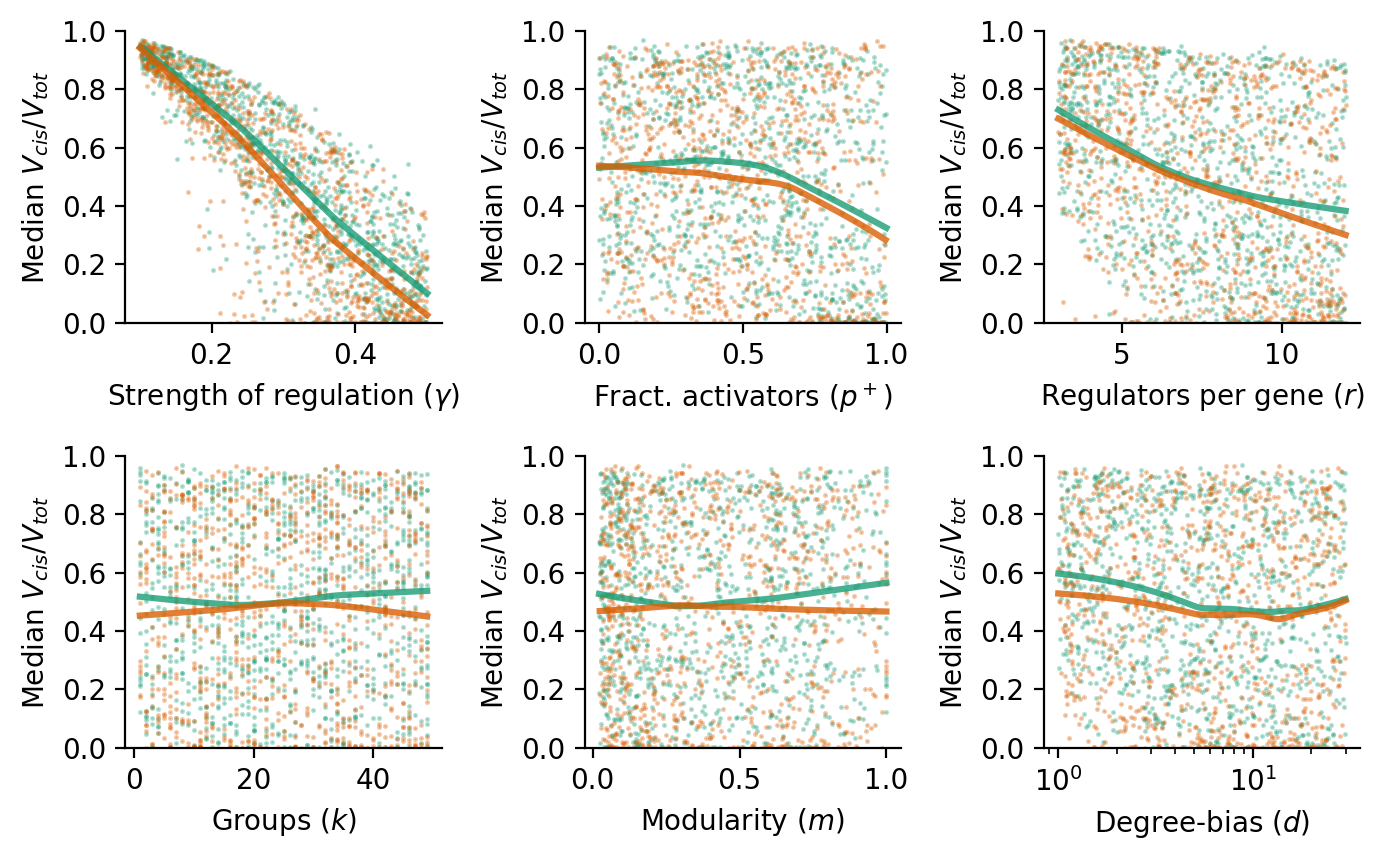

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                ['gamma','p_up','r','k','m','d'],
                                ['Strength of regulation ({})'.format(r'$\gamma$'), 
                                 'Fract. activators ({})'.format(r'$p^+$'),
                                 'Regulators per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$m$'), 
                                 'Degree-bias ({})'.format(r'$d$')
                                 ]):
    ax = axs[ix, iy]
    for i, b in enumerate([0, 1]):
        sns.regplot(data = grns.loc[grns['hier']==b], 
                    x = par, 
                    y = 'Median '+r'$V_{cis}/V_{tot}$', 
                    color = plt.get_cmap('Dark2')(i),
                    lowess = True,
                    scatter = True,
                    line_kws = dict(alpha=0.8, label=('No ' if not b else '')+'Hierarchy'),
                    scatter_kws = dict(s=0.7, alpha=0.3, label=None),
                    ax = ax
                   )
    ax.set_ylim(0, 1);
    ax.set_xlabel(label);
    if par == 'd':
        ax.set_xscale('log');
    #if ix == 0 and iy == 0:
    #    ax.legend(fontsize=7.5, frameon=False, loc='upper right');

# overall figure stuff
sns.despine();
fig.tight_layout();

## Parameter effects

Note $k$ has no effect and $m$ is only significant with hierarchy.

In [5]:
grns['y'] = grns['Median '+r'$V_{cis}/V_{tot}$']

print(sm.ols('y ~ 1 + r + gamma + p_up + k + w + d', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     2933.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:34:39   Log-Likelihood:                 1875.8
No. Observations:                2000   AIC:                            -3738.
Df Residuals:                    1993   BIC:                            -3698.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5874      0.011    149.258      0.0

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

In [6]:
grns['Mean '+r'$V_{cis}/V_{tot}$'] = grns[r'$V_{cis}/V_{tot}$'].apply(lambda x: np.quantile(x, q=0.2))
grns['y2'] = grns['Mean '+r'$V_{cis}/V_{tot}$']

print(sm.ols('y2 ~ 1 + r + gamma + p_up + k + w + d', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     3074.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:34:40   Log-Likelihood:                 1919.8
No. Observations:                2000   AIC:                            -3826.
Df Residuals:                    1993   BIC:                            -3786.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4986      0.010    144.045      0.0

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

## QTL effects

,n,r,k,w,d,gamma,p_up,hier,m,$V_{cis}/V_{tot}$,Median $V_{cis}/V_{tot}$,y,Mean $V_{cis}/V_{tot}$,y2
1470,1000,5.440911,22,18.56150,5.019554,0.301385,0.991916,False,0.469181,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.916...",0.305244,0.305244,0.166114,0.166114
654,1000,5.971934,43,2.07965,26.513807,0.354649,0.719884,True,0.047179,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.266762,0.266762,0.146503,0.146503


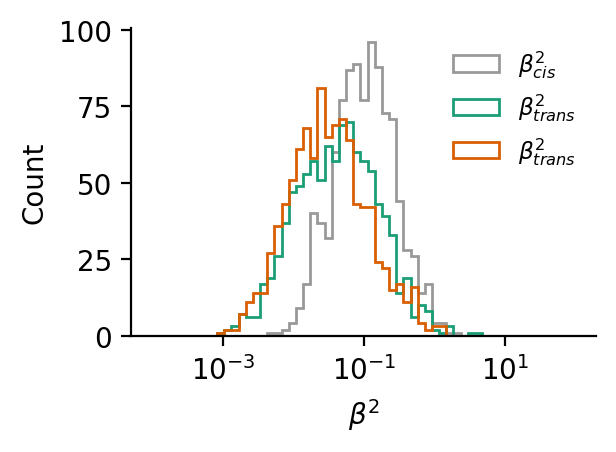

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(3,2), dpi=200)

V_cis = np.random.lognormal(np.log(0.1), 1, size=(n_genes,))
ax.hist(V_cis, 
        histtype='step', 
        bins=np.geomspace(1e-4, 1e2, 60),
        alpha=0.8,
        color='gray',
        label=r'$\beta^2_{cis}$'
);

x = grns.query('gamma < 0.4 & r < 6 & 0.166 < y & y < 0.33').sample(2)
display(x)

for ix in x.index:
    G = G_s[ix]
    G.compute_h2(np.ones(G.n));
    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    ax.hist((V_trans - np.diag(np.diag(V_trans))).max(axis=0), 
             histtype='step', 
             bins=np.geomspace(1e-4, 1e2, 60),
             label=r'$\beta^2_{trans}$'
            );
    
ax.legend(fontsize='small', frameon=False);
ax.set_xscale('log');
ax.set_xlabel(r'$\beta^2$'); 
ax.set_ylabel('Count');
sns.despine();

## Incoming and outgoing _trans_-effects

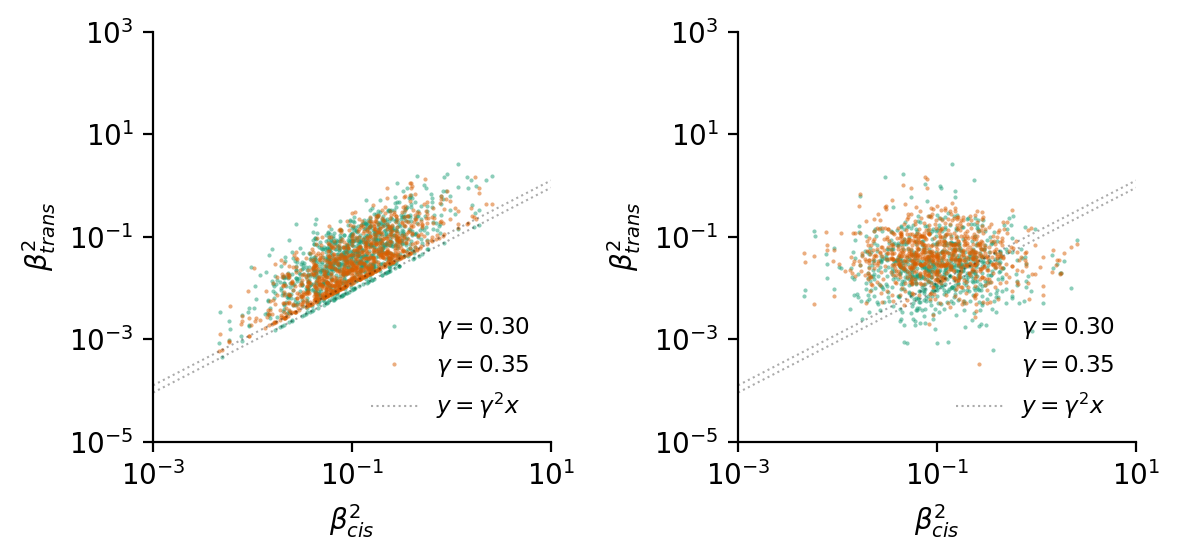

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.9), dpi=200);

V_cis = np.random.lognormal(np.log(0.1), 1, size=(1000,))

xl = np.array([1e-3,1e1])
yl = np.array([1e-5,1e3])

for i,(_,row) in enumerate(x.iterrows()):
    G = G_s[row.name]

    V_trans = (G.L @ np.diag(np.sqrt(V_cis))) ** 2

    for j in range(2):
        axs[j].plot(V_cis, (V_trans - np.diag(np.diag(V_trans))).max(axis=j),
                 '.',
                 alpha=0.5,
                 ms=1,
                 label=r'$\gamma=$'+'{:.2f}'.format(row.gamma)
                );

        axs[j].plot(xl, row.gamma**2 * xl, 'k:', alpha=0.33, linewidth=0.75, label=r'$y = \gamma^2 x$' if i==1 else None);

for ax in axs:
    ax.legend(fontsize='small', frameon=False, loc='lower right');
    ax.set_xscale('log');
    ax.set_yscale('log');
    ax.set_xlabel(r'$\beta^2_{cis}$'); 
    ax.set_ylabel(r'$\beta^2_{trans}$'); 
    ax.set_xlim(xl);
    ax.set_ylim(yl);
    
sns.despine();
fig.tight_layout();

In [9]:
grns.query('0.1 < y & y < 0.4')

,n,r,k,w,d,gamma,p_up,hier,m,$V_{cis}/V_{tot}$,Median $V_{cis}/V_{tot}$,y,Mean $V_{cis}/V_{tot}$,y2
6,1000,5.374038,5,1.523628,7.192419,0.489238,0.575610,True,0.275838,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.161883,0.161883,0.104762,0.104762
10,1000,5.706029,8,4.178207,5.174429,0.355851,0.990230,False,0.373781,"[1.0, 1.0, 1.0, 1.0, 0.8876029080054447, 1.0, ...",0.125386,0.125386,0.048661,0.048661
11,1000,8.521422,17,58.341474,1.632370,0.380442,0.692088,True,0.784777,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.87356401...",0.174182,0.174182,0.095758,0.095758
20,1000,10.104379,26,38.570013,22.343488,0.355487,0.409448,False,0.606733,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.264159,0.264159,0.191505,0.191505
31,1000,9.244277,19,97.958807,9.773400,0.484925,0.538791,False,0.844772,"[1.0, 1.0, 0.8096168470952497, 1.0, 1.0, 1.0, ...",0.137825,0.137825,0.069105,0.069105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,1000,7.609901,3,12.425962,2.694003,0.265788,0.976909,True,0.861361,"[1.0, 1.0, 1.0, 1.0, 0.9340181533564307, 1.0, ...",0.139102,0.139102,0.043187,0.043187
1978,1000,5.904038,42,1.427038,6.269332,0.478081,0.380218,False,0.033635,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.8139604208418408, ...",0.172219,0.172219,0.113922,0.113922
1982,1000,9.619419,6,2.877960,4.464835,0.250408,0.902419,False,0.365318,"[1.0, 1.0, 1.0, 0.9409957878884232, 1.0, 1.0, ...",0.259482,0.259482,0.134898,0.134898
1994,1000,7.471440,29,6.032390,9.213966,0.414387,0.410478,True,0.177254,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.136084,0.136084,0.090703,0.090703


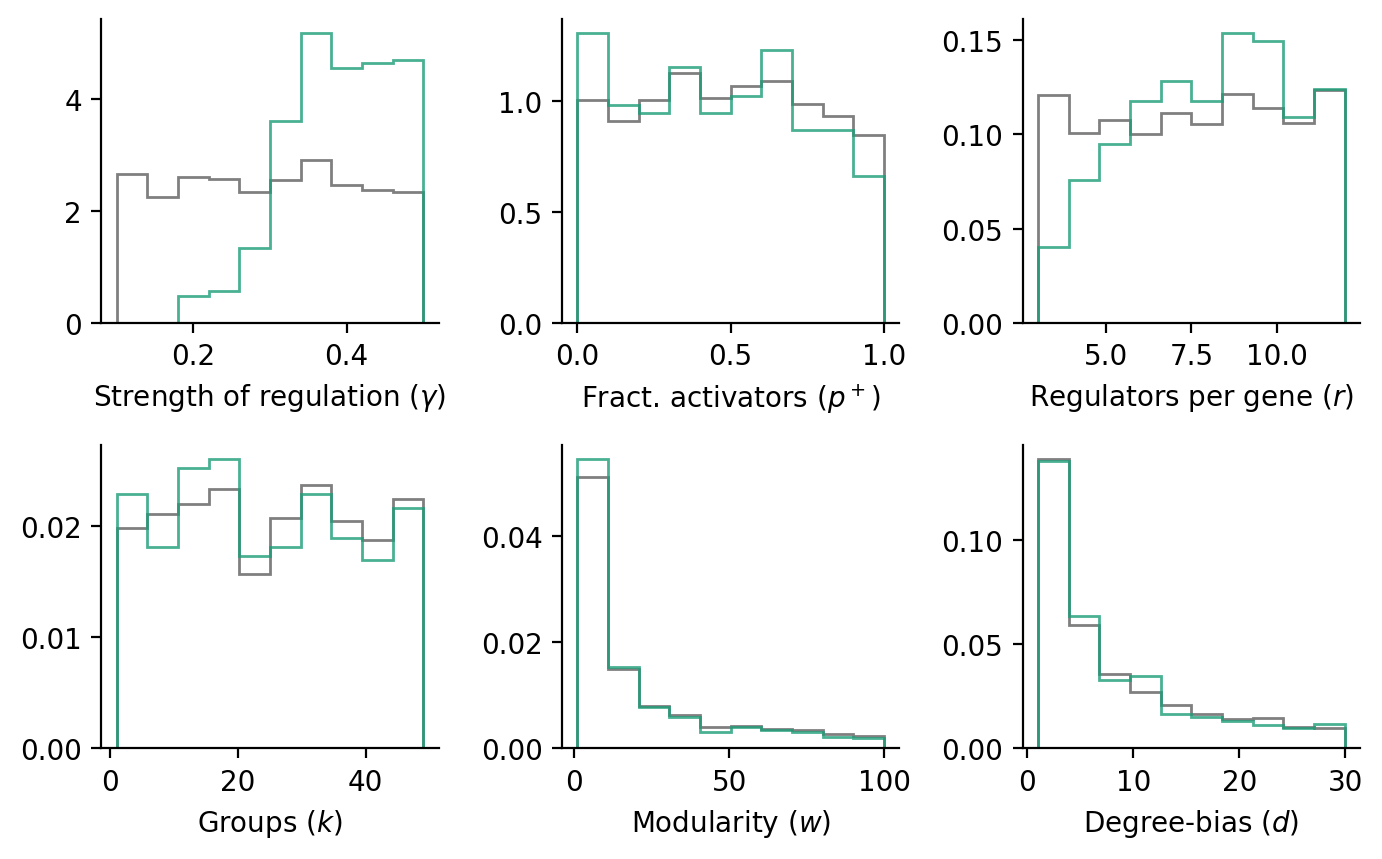

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), dpi=200)

for (ix, iy), par, label in zip(np.ndindex(axs.shape),
                                ['gamma','p_up','r','k','w','d'],
                                ['Strength of regulation ({})'.format(r'$\gamma$'), 
                                 'Fract. activators ({})'.format(r'$p^+$'),
                                 'Regulators per gene ({})'.format(r'$r$'), 
                                 'Groups ({})'.format(r'$k$'), 
                                 'Modularity ({})'.format(r'$w$'),
                                 'Degree-bias ({})'.format(r'$d$')
                                 ]):
    _, bins, _ = axs[ix,iy].hist(grns[par], histtype='step', density=True, alpha=0.5, color='k');
    _ = axs[ix,iy].hist(grns.query('0.1 < y & y < 0.4')[par], bins=bins, histtype='step', density=True, alpha=0.8);
        
    axs[ix,iy].set_xlabel(label);
        
        
sns.despine();
plt.tight_layout();

In [11]:
def count_triangles(G):
    return sum(G.subgraph(G.predecessors(n)).number_of_edges() for n in G.nodes())

def count_diamonds(G):
    return sum(len(set(G.predecessors(p1)) & set(G.predecessors(p2))) 
               for n in G.nodes() 
               for p1,p2 in itertools.combinations(G.predecessors(n), 2)
              )

grns['triangles'] = [count_triangles(G) for G in G_s]
grns['diamonds'] = [count_diamonds(G) for G in G_s]

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

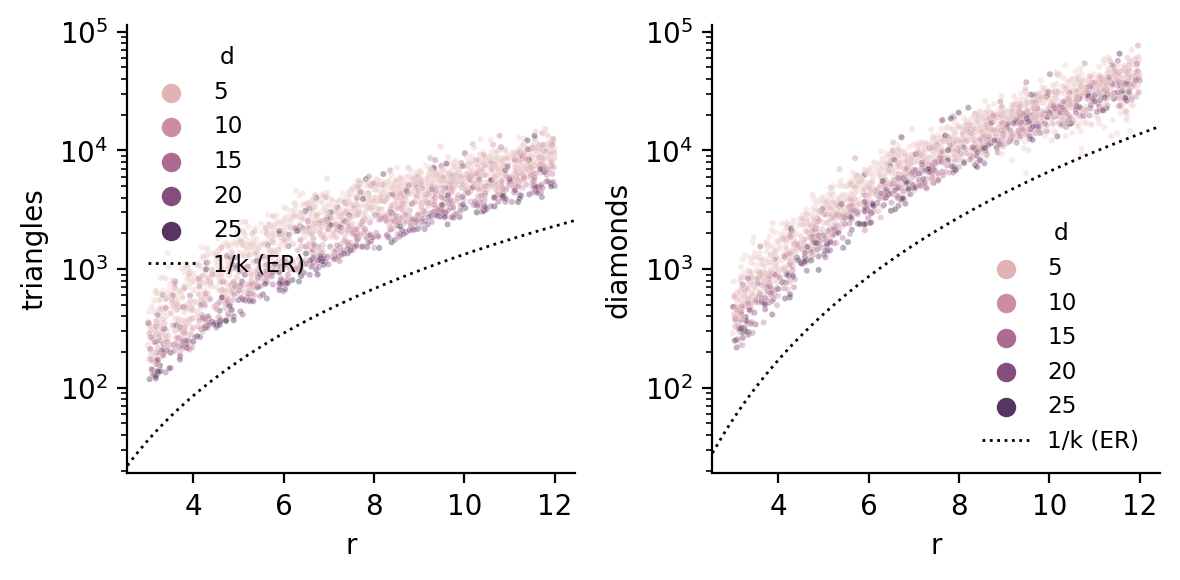

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(6,3), dpi=200)

sns.scatterplot(x = 'r', y = 'triangles', hue = 'd', alpha = 0.4, s = 5, data = grns, ax = ax[0]);
ax[0].set_yscale('log');
xl = ax[0].get_xlim()
xx = np.linspace(*xl, grns.shape[0]);
ax[0].plot(xx, scipy.special.comb(grns.n, 3) * (2 * xx / (grns.n - 1)) ** 3, 'k:', linewidth=1, label='1/k (ER)');
ax[0].set_xlim(xl);
ax[0].legend(frameon=False, title='d', fontsize='small', title_fontsize='small');

sns.scatterplot(x = 'r', y = 'diamonds', hue = 'd', alpha = 0.4, s = 5, data = grns, ax = ax[1]);
ax[1].set_yscale('log');
ax[0].set_ylim(ax[1].get_ylim());
xl = ax[1].get_xlim()
xx = np.linspace(*xl, grns.shape[0]);
ax[1].plot(xx, scipy.special.comb(grns.n, 4) * (2 * xx / (grns.n - 1)) ** 4, 'k:', linewidth=1, label='1/k (ER)');
ax[1].set_xlim(xl);
ax[1].legend(frameon=False, title='d', fontsize='small', title_fontsize='small');
ax[0].set_ylim(ax[1].get_ylim());

fig.tight_layout();
sns.despine();

In [13]:
print(sm.ols('triangles ~ 1 + r + k + w + d', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:              triangles   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     2124.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:39:24   Log-Likelihood:                -17104.
No. Observations:                2000   AIC:                         3.422e+04
Df Residuals:                    1995   BIC:                         3.425e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2936.1040    106.957    -27.451      0.0

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

In [14]:
print(sm.ols('diamonds ~ 1 + r + k + w + d', data = grns).fit().summary());

                            OLS Regression Results                            
Dep. Variable:               diamonds   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     1780.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:39:24   Log-Likelihood:                -20274.
No. Observations:                2000   AIC:                         4.056e+04
Df Residuals:                    1995   BIC:                         4.059e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.719e+04    521.706    -32.948      0.0

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego

In [15]:
print(sm.ols('y ~ 1 + r + gamma + p_up + w + d + diamonds', data = grns).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     2945.
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               0.00
Time:                        01:39:24   Log-Likelihood:                 1879.5
No. Observations:                2000   AIC:                            -3745.
Df Residuals:                    1993   BIC:                            -3706.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6133      0.012    138.403      0.0

/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_categorical_dtype(dt)
/Users/magu/opt/anaconda3/lib/python3.9/site-packages/patsy/util.py:672: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return _pandas_is_catego